In [1]:
from __future__ import print_function

import csv
import numpy as np

from model import get_model
from utils import real_to_cdf, preprocess

Using TensorFlow backend.


In [2]:
def load_validation_data():
    """
    Load validation data from .npy files.
    """
    X = np.load('data/X_validate.npy')
    ids = np.load('data/ids_validate.npy')

    X = X.astype(np.float32)
    X /= 255

    return X, ids



In [3]:
def accumulate_study_results(ids, prob):
    """
    Accumulate results per study (because one study has many SAX slices),
    so the averaged CDF for all slices is returned.
    """
    sum_result = {}
    cnt_result = {}
    size = prob.shape[0]
    for i in range(size):
        study_id = ids[i]
        idx = int(study_id)
        if idx not in cnt_result:
            cnt_result[idx] = 0.
            sum_result[idx] = np.zeros((1, prob.shape[1]), dtype=np.float32)
        cnt_result[idx] += 1
        sum_result[idx] += prob[i, :]
    for i in cnt_result.keys():
        sum_result[i][:] /= cnt_result[i]
    return sum_result



In [4]:
print('Loading and compiling models...')
model_systole = get_model()
model_diastole = get_model()

print('Loading models weights...')
model_systole.load_weights('weights_systole_best.hdf5')
model_diastole.load_weights('weights_diastole_best.hdf5')

    # load val losses to use as sigmas for CDF
with open('val_loss.txt', mode='r') as f:
    val_loss_systole = float(f.readline())
    val_loss_diastole = float(f.readline())

print('Loading validation data...')
X, ids = load_validation_data()

print('Pre-processing images...')
X = preprocess(X)

batch_size = 32
print('Predicting on validation data...')
pred_systole = model_systole.predict(X, batch_size=batch_size, verbose=1)
pred_diastole = model_diastole.predict(X, batch_size=batch_size, verbose=1)
# real predictions to CDF
cdf_pred_systole = real_to_cdf(pred_systole, val_loss_systole)
cdf_pred_diastole = real_to_cdf(pred_diastole, val_loss_diastole)
print('Accumulating results...')
sub_systole = accumulate_study_results(ids, cdf_pred_systole)
print('sys print')
print(sub_systole)
sub_diastole = accumulate_study_results(ids, cdf_pred_diastole)
print('dia print')
print(sub_diastole)
# write to submission file

Loading and compiling models...
Loading models weights...
Loading validation data...
Pre-processing images...
21/21 [==============================] - 3s     
Predicting on validation data...
21/21 [==============================] - 2s
Accumulating results...
sys print
{501: array([[ 0.09682275,  0.10097837,  0.10526194,  0.10967486,  0.11421843,
         0.1188938 ,  0.12370207,  0.12864415,  0.13372086,  0.13893287,
         0.14428075,  0.14976481,  0.15538538,  0.16114251,  0.16703616,
         0.17306611,  0.17923197,  0.18553323,  0.19196913,  0.19853882,
         0.20524125,  0.2120752 ,  0.21903925,  0.22613183,  0.2333512 ,
         0.24069543,  0.24816243,  0.25574994,  0.26345545,  0.27127644,
         0.27921003,  0.28725332,  0.29540318,  0.30365634,  0.31200933,
         0.32045859,  0.32900035,  0.33763078,  0.34634575,  0.35514125,
         0.3640129 ,  0.37295634,  0.38196701,  0.39104027,  0.40017152,
         0.40935579,  0.41858825,  0.42786393,  0.43717775,  0.4465

In [5]:
%matplotlib inline

import matplotlib

In [6]:
from __future__ import division
from IPython.display import display, HTML
def isclose(a, b, rel_tol=1e-02, abs_tol=0.0):
    return abs(b-a) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

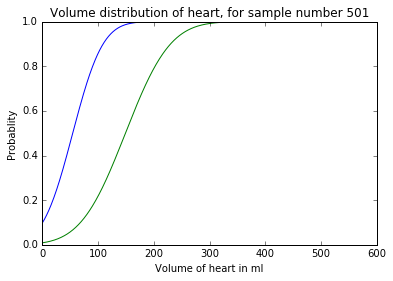

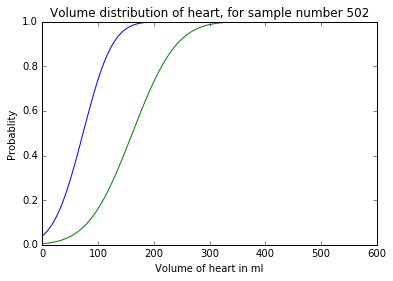

In [7]:
import matplotlib.pyplot as plt
for key in sub_systole:
    idx = 0
    for prob in sub_systole[key][0]:
        if (prob > 0.88):
            #print('systole volume is: {0}'.format(idx))
            sys_vol = idx
            break
        idx+=1
    vs = idx
    plt.plot(range(0,600),sub_systole[key][0])
    idx = 0
    for prob in sub_diastole[key][0]:
        if (prob > 0.70):
            #print('diastole volume is : {0}'.format(idx))
            dis_vol = idx
            break
        idx+=1
    vd = idx
    ratio = 0.0
    ratio = ((vd - vs)/vd)*100
    #print('ef is : {0}'.format(ratio))
    if(ratio > 40):
        htmlStr = """<html>
<head>
<!-- Latest compiled and minified CSS -->
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.6/css/bootstrap.min.css" integrity="sha384-1q8mTJOASx8j1Au+a5WDVnPi2lkFfwwEAa8hDDdjZlpLegxhjVME1fgjWPGmkzs7" crossorigin="anonymous">

<!-- Optional theme -->
<link rel="stylesheet" href="https://bootswatch.com/cosmo/bootstrap.min.css" >

<!-- Latest compiled and minified JavaScript -->
<script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.6/js/bootstrap.min.js" integrity="sha384-0mSbJDEHialfmuBBQP6A4Qrprq5OVfW37PRR3j5ELqxss1yVqOtnepnHVP9aJ7xS" crossorigin="anonymous"></script>
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.5.0/css/font-awesome.min.css">
<head>
<body>

<a href="#" class="btn btn-default btn-lg btn-success disabled"><i class="fa fa-check-square-o"></i> Ejection Fraction of this
sample is {0:.2f}%.
This is considered normal
<br>Systole volume: {1} ml
<br>Diastole volume: {2} ml
</a> 
</body>
<html>
        """.format(ratio, sys_vol, dis_vol)
        display(HTML(htmlStr))
    else:
        htmlStr = """<html>
<head>
<!-- Latest compiled and minified CSS -->
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.6/css/bootstrap.min.css" integrity="sha384-1q8mTJOASx8j1Au+a5WDVnPi2lkFfwwEAa8hDDdjZlpLegxhjVME1fgjWPGmkzs7" crossorigin="anonymous">

<!-- Optional theme -->
<link rel="stylesheet" href="https://bootswatch.com/cosmo/bootstrap.min.css" >

<!-- Latest compiled and minified JavaScript -->
<script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.6/js/bootstrap.min.js" integrity="sha384-0mSbJDEHialfmuBBQP6A4Qrprq5OVfW37PRR3j5ELqxss1yVqOtnepnHVP9aJ7xS" crossorigin="anonymous"></script>
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.5.0/css/font-awesome.min.css">
<head>
<body>
<a href="#" class="btn btn-default btn-lg btn-danger disabled"><i class="fa fa-exclamation-triangle"></i> Ejection Fraction
of this sample is {0:.2f}%.
Which is below normal limit
<br>Systole volume: {1} ml
<br>Diastole volume: {2} ml
</a> 

</body>
<html>""".format(ratio, sys_vol, dis_vol)
        display(HTML(htmlStr))
    plt.plot(range(0,600),sub_diastole[key][0])
    plt.ylabel('Probablity')
    plt.xlabel('Volume of heart in ml')
    plt.title('Volume distribution of heart, for sample number {0}'.format(key))
    plt.show()
